# Results notebook

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from config import CONFIG_mkB
from hospital_model import hospital_model

### 20 independent seeds, comparing three configurations (pairwise)

In [2]:
# --- simulate 20 independent samples, and compare the facility configurations for all 20 ---
results_all = [[],[],[]]

# loop over configs
for seed in range(20): # use numbers 1-20 as the seeds for simplicity.
    results_for_this_seed = []
    conf = copy.deepcopy(CONFIG_mkB)
    conf['seed'] = seed # initializing hospital_model also resets the random generator with this seed.
    conf['total'] = [5,1,5]
    for layout in [[3,1,4],[3,1,5],[4,1,5]]: # facility configs to be compared
        conf['staffed'] = layout
        hospital = hospital_model(conf)
        hospital.run_for(100) # warm up from sim init
        # clear the result so warm-up is not included
        hospital.results['patient_flow'] = []
        # hospital.results['patient_counts'] = [0,0,0,0] # do not reset, only matters at end of sim.
        hospital.results['total_active'] = [0,0,0]
        hospital.results['util_active'] = [0,0,0]
        hospital.results['snapshots'] = []
        hospital.results['or_time_blocked'] = 0
        hospital.run_for(1000) # actual simulation run
        results_for_this_seed.append(hospital.results) # per-config results
    results_all[0].append(results_for_this_seed[0])
    results_all[1].append(results_for_this_seed[1])
    results_all[2].append(results_for_this_seed[2])

# result analysis:
print('Operating room was stuck waiting for a recovery spot _ % of the time:')
or_blocked_percentage = []
or_blocked_time = 0
for a in results_all[0]:
    or_blocked_percentage.append([s['queues'][2] for s in a['snapshots']])
    or_blocked_time += a['or_time_blocked']
print('3-1-4: ', sum([len([b for b in a if b != 0]) for a in or_blocked_percentage]) / sum([len(a) for a in or_blocked_percentage]) * 100)
or_blocked_percentage = []
for a in results_all[1]:
    or_blocked_percentage.append([s['queues'][2] for s in a['snapshots']])
print('3-1-5: ', sum([len([b for b in a if b != 0]) for a in or_blocked_percentage]) / sum([len(a) for a in or_blocked_percentage]) * 100)
or_blocked_percentage = []
for a in results_all[2]:
    or_blocked_percentage.append([s['queues'][2] for s in a['snapshots']])
print('4-1-4: ', sum([len([b for b in a if b != 0]) for a in or_blocked_percentage]) / sum([len(a) for a in or_blocked_percentage]) * 100)

print('All recovery rooms were occupied for _ % of the time')
print('3-1-4: ', len([a['patient_counts'][3] for a in results_all[0] if a['patient_counts'][3] == 5])
      / len([a['patient_counts'][3] for a in results_all[0]]))
print('3-1-5: ', len([a['patient_counts'][3] for a in results_all[1] if a['patient_counts'][3] == 5])
      / len([a['patient_counts'][3] for a in results_all[1]]))
print('4-1-5: ', len([a['patient_counts'][3] for a in results_all[2] if a['patient_counts'][3] == 5])
      / len([a['patient_counts'][3] for a in results_all[2]]))

Operating room was stuck waiting for a recovery spot _ % of the time:
3-1-4:  2.875
3-1-5:  0.5499999999999999
4-1-4:  0.8
All recovery rooms were occupied for _ % of the time
3-1-4:  0.0
3-1-5:  0.05
4-1-5:  0.0


### Twist

In [19]:
conf = copy.deepcopy(CONFIG_mkB) # prevent side effect on default configuration
conf['seed'] = 0
conf['total'] = [5,5,5] # increase slack capacity for demo. changes to this conf param mid-simulation may cause issues
conf['staffed'] = [3,1,3]
hospital = hospital_model(conf)
hospital.run_for(1000)
conf['staffed'] = [0,1,3] # change what facilities are staffed
hospital.run_for(1000)
conf['staffed'] = [3,1,3]
hospital.run_for(1000)

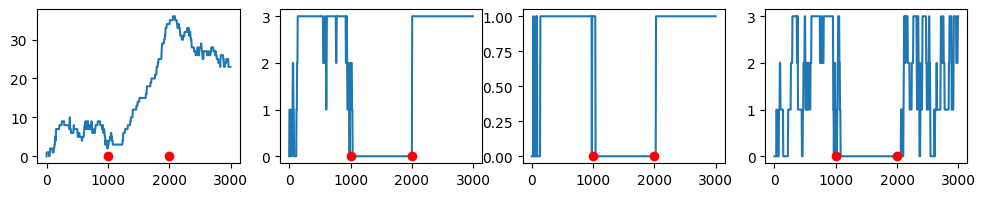

In [20]:
# visualize rooms: note spike when applying a config change.
plot_stages = len(hospital.results['snapshots'][0]['patient_counts']) # plot each metric monitored by snapshots
fig, axs = plt.subplots(figsize=(3*plot_stages,2),ncols = plot_stages)
x = [s['time'] for s in hospital.results['snapshots']] # snapshot times on x-axis
for a in range(len(axs)):
    axs[a].plot(x,[s['patient_counts'][a] for s in hospital.results['snapshots']])
    axs[a].plot([1000,2000],[0,0],'ro') # example param changes

OR utilization: 0.8%
OR blocked for 12.6% of the time
OR was waiting for REC 0.12666666666666668 of the simulation


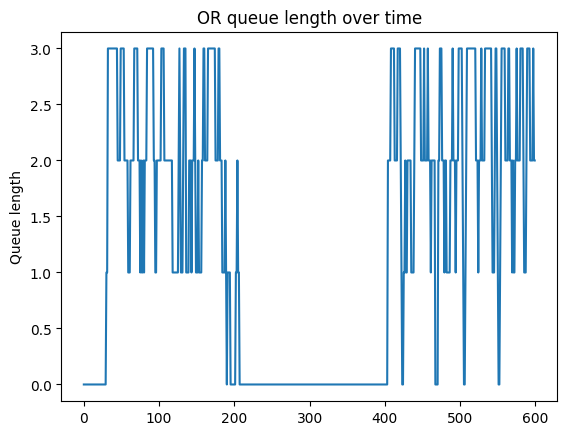

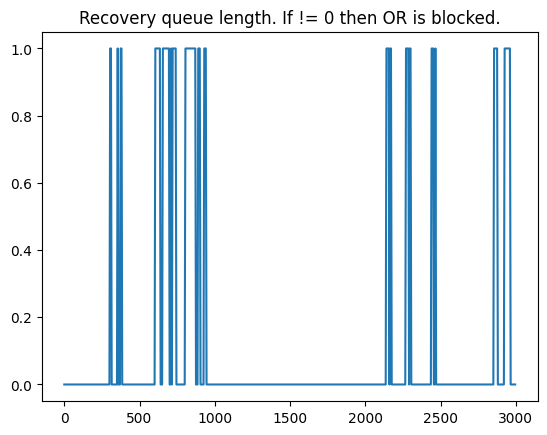

In [21]:
queue_lengths = []#list of or queue lengths
blocked_time = hospital.results["or_time_blocked"]#total or blocked time
total_time = hospital.results["snapshots"][-1]["time"]#total simulation time
for snapshot in hospital.results["snapshots"]:
    queue_lengths.append(snapshot["queues"][1])

plt.figure(0)
plt.plot(queue_lengths)

plt.title("OR queue length over time")
plt.ylabel("Queue length")

active_times = hospital.results["util_active"]
total_times  = hospital.results["total_active"]
print(f'OR utilization: {np.round(active_times[1]/total_times[1],3)}%')
print(f'OR blocked for {np.round(blocked_time/total_time,3)*100}% of the time')

# -- calculate OR block from queue lengths --
# array of each snapshots queue length in rec room.
# note that the data is compressed to 1 and 0 to ignore overshoot caused by slack capacity.
or_blocked = [int(y['queues'][2] != 0) for y in hospital.results['snapshots']]
print('OR was waiting for REC %s of the simulation' % (sum(or_blocked) / len(or_blocked)))
plt.figure(1) # plot monitor of recovery queue
plt.title('Recovery queue length. If != 0 then OR is blocked.')
plt.plot(x, or_blocked) # check for != 0 then cast back to int for plotting

### Finding twisted version with similar operating room utilization as non-twisted

In [22]:
conf = copy.deepcopy(CONFIG_mkB) # prevent side effect on default configuration
conf['total'] = [10,10,10]
conf['staffed'] = [3,1,2] # same for both twisted and non.
print('patients actually being treated / patients spent in op room:')

# --- non-twisted ---
hospital = hospital_model(conf)
hospital.run_for(4000)
print('no twist:', hospital.results['util_active'][1] / hospital.results['total_active'][1])

# -- twisted: electrical outage for time 1000 to 1500
hospital = hospital_model(conf)
conf['means'][0] = 45
hospital.run_for(1000)
conf['staffed'] = [0,0,0]
hospital.run_for(500)
conf['staffed'] = [3,1,2]
hospital.run_for(3500)
print('yeah twist, and arrival time distr. increased to 35: ', hospital.results['util_active'][1] / hospital.results['total_active'][1])

patients actually being treated / patients spent in op room:
no twist: 0.6807787725141976
yeah twist, and arrival time distr. increased to 35:  0.45215832239286585


# Task 4 from here on

In [33]:
# --- alt. ver of config comparison.
def simulate(samples,rooms,times_exp,times_unif):
    out = rooms[0]
    utilizations = [[],[]] # nested list for both twisted and untwisted
    blocked = [[],[]]
    queue_lenghts = [[],[]]
    for sample in range(samples):

        conf = copy.deepcopy(CONFIG_mkB) # prevent side effect on default configuration
        conf['seed'] = sample # all hospital configurations use the same seed, but there is n different seeds total.
        conf['total'] = [10,10,10] # increase slack capacity for demo. changes to this conf param dont have effect mid-simulation
        conf["means"]=times_exp
        conf["unif"]=times_unif
        conf['staffed'] = rooms # change what facilities are staffed

        # --- Simulate without twist ---
        hospital = hospital_model(conf)

        #print(hospital.env.now)
        hospital.run_for(500) # warm up (now 500 instead of 100)
        env_time = hospital.env.now #env time after warmup
        #print(env_time)
        #Resetting statsistics
        hospital.results['patient_flow'] = []
        hospital.results['total_active'] = [0,0,0]
        hospital.results['util_active'] = [0,0,0]
        hospital.results['snapshots'] = []
        hospital.results['or_time_blocked'] = 0

        hospital.run_for(10000)#actual simulation run
        active_times = hospital.results["util_active"]
        total_times  = hospital.results["total_active"]
        blocked_time = hospital.results["or_time_blocked"]

        total_time = hospital.results["snapshots"][-1]["time"] -env_time #total simulation time,simulation time at the end - warmup time
        sample_q_times = []
        for snapshot in hospital.results["snapshots"]:
            sample_q_times.append(snapshot["queues"][1])
        queue_lenghts[0].append(np.mean(sample_q_times))
        utilizations[0].append(np.round(active_times[1]/total_time,5)*100)
        blocked[0].append(np.round(blocked_time/total_time,3)*100)

        
        # --- Simulate with twist ---
        hospital = hospital_model(conf)

        #print(hospital.env.now)
        hospital.run_for(500) # warm up (now 500 instead of 100)
        env_time = hospital.env.now #env time after warmup
        #print(env_time)
        #Resetting statsistics
        hospital.results['patient_flow'] = []
        hospital.results['total_active'] = [0,0,0]
        hospital.results['util_active'] = [0,0,0]
        hospital.results['snapshots'] = []
        hospital.results['or_time_blocked'] = 0

        hospital.run_for(4000) # actual simulation run, split into before, electrical outage of prep facilities, and after
        conf['staffed'][0] = 0
        hospital.run_for(1000)
        conf['staffed'][0] = out
        hospital.run_for(5000)
        
        active_times = hospital.results["util_active"]
        total_times  = hospital.results["total_active"]
        blocked_time = hospital.results["or_time_blocked"]

        total_time = hospital.results["snapshots"][-1]["time"] -env_time #total simulation time,simulation time at the end - warmup time
        sample_q_times = []
        for snapshot in hospital.results["snapshots"]:
            sample_q_times.append(snapshot["queues"][1])
        queue_lenghts[1].append(np.mean(sample_q_times))
        utilizations[1].append(np.round(active_times[1]/total_time,5)*100)
        blocked[1].append(np.round(blocked_time/total_time,3)*100)

    print(f'Statistics for {rooms[0]}p {rooms[2]}r configuration ')
    print(f'with {times_exp}m and {times_unif}u') # also print config used
    print(f'MEAN utilization: {np.round(np.mean(utilizations[0]),3)}% and with twist {np.round(np.mean(utilizations[1]),3)}%')
    print(f'MEAN blocked: {np.round(np.mean(blocked[0]),3)}% and with twist {np.round(np.mean(blocked[1]),3)}%')
    print("--------------------------------")
    return utilizations,blocked,queue_lenghts

Statistics for 4p 4r configuration 
with [25, 40, 20, 40]m and [(20, 30), None, None, None]u
MEAN utilization: 79.895% and with twist 78.243%
MEAN blocked: 1.54% and with twist 2.03%
--------------------------------
Statistics for 4p 4r configuration 
with [22.5, 40, 20, 40]m and [None, (30, 50), None, (30, 50)]u
MEAN utilization: 86.815% and with twist 82.258%
MEAN blocked: 2.32% and with twist 2.42%
--------------------------------
Statistics for 4p 4r configuration 
with [25, 40, 20, 40]m and [None, None, None, None]u
MEAN utilization: 82.417% and with twist 79.631%
MEAN blocked: 2.42% and with twist 2.83%
--------------------------------
Statistics for 4p 4r configuration 
with [25, 40, 20, 40]m and [(20, 30), (30, 50), None, (30, 50)]u
MEAN utilization: 80.984% and with twist 79.625%
MEAN blocked: 1.1% and with twist 1.97%
--------------------------------
Statistics for 5p 4r configuration 
with [25, 40, 20, 40]m and [(20, 30), None, None, None]u
MEAN utilization: 79.864% and with

Text(0, 0.5, 'Average or usage')

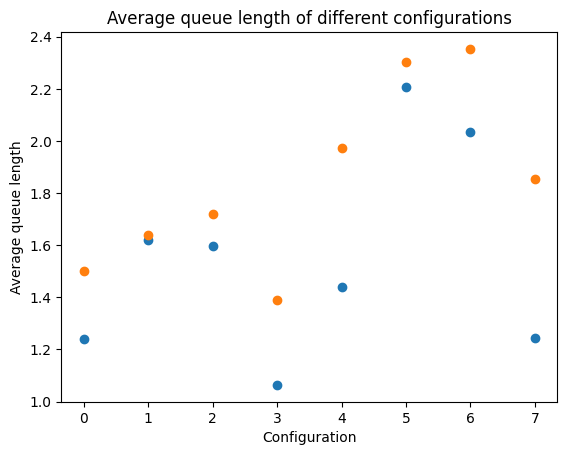

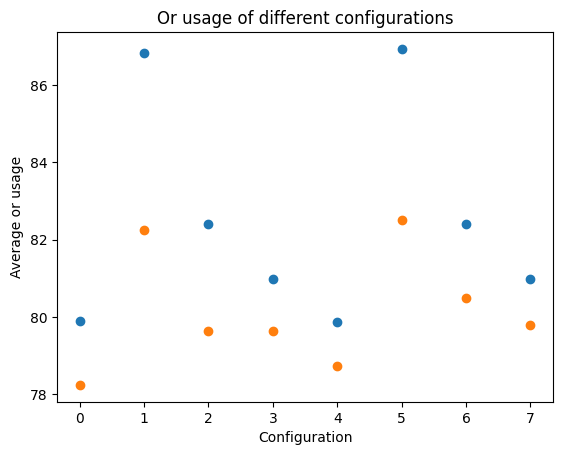

In [34]:
import pandas as pd
configurations = [
    #4 prep,4 rec
    [[4,1,4],[25,40,20,40],[(20,30),None,None,None]],
    [[4,1,4],[22.5,40,20,40],[None,(30,50),None,(30,50)]],
    [[4,1,4],[25,40,20,40],[None,None,None,None]],
    [[4,1,4],[25,40,20,40],[(20,30),(30,50),None,(30,50)]],
    #5 prep,4 rec
     [[5,1,4],[25,40,20,40],[(20,30),None,None,None]],
    [[5,1,4],[22.5,40,20,40],[None,(30,50),None,(30,50)]],
    [[5,1,4],[25,40,20,40],[None,None,None,None]],
    [[5,1,4],[25,40,20,40],[(20,30),(30,50),None,(30,50)]],
]

results = pd.DataFrame(columns=["avg_queue_length","avg_queue_per_sample","config","or_usage"])
resultsTwist = pd.DataFrame(columns=["avg_queue_length","avg_queue_per_sample","config","or_usage"])
for i,conf in enumerate(configurations):
    
    utilizations,blocked,queue = simulate(samples = 10,rooms=conf[0],times_exp = conf[1],times_unif = conf[2])
    results.loc[len(results)] = [np.mean(queue[0]),queue[0],i,np.mean(utilizations[0])]
    resultsTwist.loc[len(results)] = [np.mean(queue[1]),queue[1],i,np.mean(utilizations[1])]

data = pd.DataFrame(columns=["queue","config"])
data["queue"]=results["avg_queue_length"]
data["config"]=results["config"]
data["usage"]=results["or_usage"]

data2 = pd.DataFrame(columns=["queue","config"])
data2["queue"]=resultsTwist["avg_queue_length"]
data2["config"]=resultsTwist["config"]
data2["usage"]=resultsTwist["or_usage"]

plt.figure(0)
plt.scatter(data["config"],data["queue"])
plt.scatter(data2["config"],data2["queue"])
plt.title("Average queue length of different configurations")
plt.xlabel("Configuration")
plt.ylabel("Average queue length")

plt.figure(1)
plt.scatter(data["config"],data["usage"])
plt.scatter(data2["config"],data2["usage"])
plt.title("Or usage of different configurations")
plt.xlabel("Configuration")
plt.ylabel("Average or usage")


Blue: untwisted

Orange: twisted, electrical outage of all prep facilities between 4000 and 5000 simulation time

it can be seen that queue length increases as patients wait at the entrance, and operating room usage is reduced, as there is now idle time when prep rooms cannot accept new processes.

### Extract OR Waiting-Time Series

In [35]:
def _extract_or_wait_series(results, conf=None, burn_in_time=0.0, clip_negative=True):
    """
    Returns a 1D numpy array of per-patient OR waiting times ordered by OR entry time.
    clip_negative:
      if True, negative values are clipped to 0.
    """
    if 'patient_flow' not in results or len(results['patient_flow']) == 0:
        raise ValueError("results does not contain non-empty 'patient_flow'.")

    flows = results['patient_flow']

    # Build rows: (or_start, prep_start)
    rows = []
    for f in flows:
        # Defensive: skip incomplete records
        if f is None or len(f) < 3:
            continue
        prep_start = f[1]
        or_start = f[2]
        if or_start == 0 or prep_start == 0:
            # 0 indicates "not reached yet" in your model initialization
            continue
        if or_start < burn_in_time:
            # discard patients whose or_start < burn_in_time.
            continue
        rows.append((or_start, prep_start))

    if not rows:
        raise ValueError("No usable patient records after filtering (burn-in or incomplete flows).")

    rows.sort(key=lambda x: x[0])

    gap = np.array([or_start - prep_start for (or_start, prep_start) in rows], dtype=float)

    if conf is not None and 'means' in conf and len(conf['means']) >= 2:
        prep_mean = float(conf['means'][1])
        wait = gap - prep_mean
    else:
        wait = gap

    if clip_negative:
        wait = np.maximum(wait, 0.0)

    return wait

### Serial Correlation Plotting Function

In [36]:
def plot_wait_correlation(results, conf=None, lag=1, max_lag=30, burn_in_time=0.0):
    """
    Plot serial correlation of per-patient OR waiting times (ordered by OR entry).
    """
    w = _extract_or_wait_series(results, conf=conf, burn_in_time=burn_in_time)

    if len(w) <= lag:
        raise ValueError(f"Not enough patients to compute lag-{lag} correlation (n={len(w)}).")

    # Correlation at specific lag
    x = w[:-lag]
    y = w[lag:]
    corr_lag = float(np.corrcoef(x, y)[0, 1])

    # Correlation by lag
    corr_by_lag = []
    for L in range(1, max_lag + 1):
        if len(w) <= L:
            corr_by_lag.append(np.nan)
            continue
        c = np.corrcoef(w[:-L], w[L:])[0, 1]
        corr_by_lag.append(float(c))

    # Scatter
    plt.figure()
    plt.scatter(x, y, s=10)
    plt.title(f"Serial correlation of OR waiting times (lag={lag}), r={corr_lag:.3f}")
    plt.xlabel("w[t] (OR wait)")
    plt.ylabel(f"w[t+{lag}] (OR wait)")
    plt.grid(True)

    # correlation by lag
    plt.figure()
    plt.plot(range(1, max_lag + 1), corr_by_lag, marker='o')
    plt.title("Correlation of OR waiting time by lag")
    plt.xlabel("Lag")
    plt.ylabel("Pearson correlation")
    plt.grid(True)

    return {
        "wait_series": w,
        "corr_lag": corr_lag,
        "corr_by_lag": corr_by_lag
    }

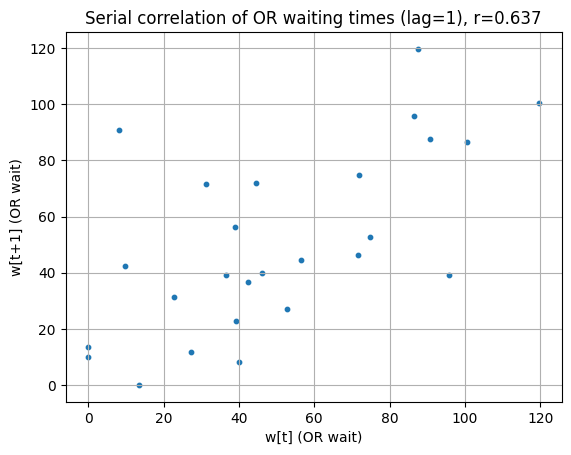

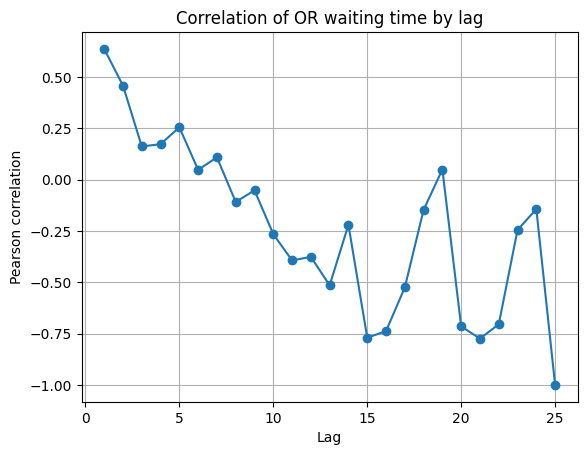

In [38]:
plotted_values = plot_wait_correlation(hospital.results, conf=hospital.conf, lag=1, max_lag=30, burn_in_time=0.0)

In [39]:
plotted_values

{'wait_series': array([  0.        ,  13.52769446,   0.        ,   9.81043505,
         42.40170711,  36.62890195,  39.25789745,  22.90527996,
         31.2896918 ,  71.54935935,  46.23732707,  40.03173492,
          8.05782709,  90.86551174,  87.56409836, 119.72074878,
        100.51821868,  86.50852911,  95.89962033,  39.08601136,
         56.44739805,  44.48604683,  71.85883182,  74.74281919,
         52.83075826,  27.20749552,  11.86642742]),
 'corr_lag': 0.6366209804511088,
 'corr_by_lag': [0.6366209804511088,
  0.4579135544828299,
  0.16168724839333137,
  0.17259246672494966,
  0.25503393350906045,
  0.0477022273596684,
  0.10867827516961562,
  -0.10884085676308478,
  -0.05213711407271448,
  -0.26543932054810004,
  -0.3937542891977687,
  -0.37608835079659075,
  -0.5148249189451297,
  -0.21981563729038997,
  -0.7700838374372839,
  -0.7380859721153378,
  -0.5253519591473417,
  -0.147496768756578,
  0.04928611147670399,
  -0.7150011704542464,
  -0.774205480334997,
  -0.7049124324288